HDBSCAN is not only great for clustering but also effective for anomaly detection because:

✅ It automatically detects outliers (labeled as -1).
✅ It works well with complex, non-linear data distributions.
✅ It provides a cluster membership probability score, helping to rank anomalies based on how confidently they don’t belong to any cluster.

In [47]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import kagglehub

import hdbscan

import os

from sklearn.preprocessing import StandardScaler

In [48]:

# Define the file path
dataset_path = "/Users/Dataghost/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv"

df = pd.read_csv(dataset_path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [49]:
# Select a subset of features for visualization

features = ["V1", "V2", "V3", "V4", "V5"]

df_selected = df[features]

In [50]:
# Standardize the dataset (HDBSCAN performs better with standardized data)

scaler = StandardScaler()

X_scaled = scaler.fit_transform(selected_features)

# Show dataset info

df_selected.head()

,V1,V2,V3,V4,V5
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321
1,1.191857,0.266151,0.166480,0.448154,0.060018
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309
4,-1.158233,0.877737,1.548718,0.403034,-0.407193


Step 2️⃣: Train HDBSCAN for Anomaly Detection

HDBSCAN assigns cluster labels to normal transactions and -1 to outliers (fraudulent transactions).

In [51]:
# Train HDBSCAN model

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)

labels = clusterer.fit_predict(X_scaled)

# Add labels to the dataset

df_selected['Cluster'] = labels

/var/folders/zr/xhd5gptd36zgdy5mmcv4gjfc0000gp/T/ipykernel_51428/2816885975.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Cluster'] = labels


In [52]:
# Count normal vs anomaly points

normal_points = (labels != -1).sum()

anomaly_points = (labels == -1).sum()

print(f"🔹 Normal Points: {normal_points}")

print(f"\n🔹 Anomalies (Outliers): {anomaly_points}")

🔹 Normal Points: 83574

🔹 Anomalies (Outliers): 201233


Step 3️⃣: Visualize Anomalies vs Normal Transactions

We will color anomalies (fraudulent transactions) in red and normal transactions in blue.

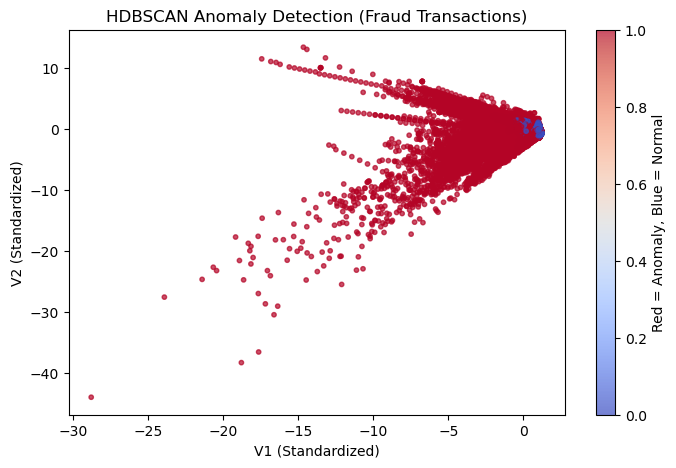

In [55]:
plt.figure(figsize=(8,5))

plt.scatter(X_scaled[:,0], 
            X_scaled[:,1], 
            c=(labels == -1), 
            cmap='coolwarm', 
            alpha=0.7,
            s=10
            
            )

plt.title("HDBSCAN Anomaly Detection (Fraud Transactions)")

plt.xlabel("V1 (Standardized)")

plt.ylabel("V2 (Standardized)")

plt.colorbar(label='Red = Anomaly, Blue = Normal')

plt.show()

Step 4️⃣: Extract the Top Anomalies Based on Cluster Probabilities

HDBSCAN not only identifies anomalies but also gives a probability score indicating how strongly a point belongs to a cluster.

In [56]:
# Get probability scores for each point

df_selected['Anomaly Score'] = 1- clusterer.probabilities_

# Sort anomalies by highest anomaly score

top_anomalies = df_selected[df_selected['Cluster']== -1].sort_values(by='Anomaly Score', ascending=False)

# Display the most anomalous transactions

top_anomalies.head()



/var/folders/zr/xhd5gptd36zgdy5mmcv4gjfc0000gp/T/ipykernel_51428/2275620261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Anomaly Score'] = 1- clusterer.probabilities_


,V1,V2,V3,V4,V5,Cluster,Anomaly Score
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,-1,1.0
189118,-0.573998,0.353102,-0.078381,-2.285745,1.596285,-1,1.0
189122,-1.566762,0.676917,0.182123,-2.078907,0.619391,-1,1.0
189123,1.626338,-0.586209,-1.900482,0.413404,0.109142,-1,1.0
189124,-1.327157,1.939796,-0.737618,2.615674,3.061929,-1,1.0


Key Takeaways from Anomaly Detection with HDBSCAN


✅ HDBSCAN successfully identifies fraudulent transactions as anomalies (Cluster -1).
✅ It ranks anomalies using an anomaly score, allowing us to detect the most suspicious transactions first.
✅ Unlike K-Means, HDBSCAN does not force all points into clusters, making it better suited for fraud detection.